In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [7]:
class FaceRecognitionTF:
    def __init__(self, input_shape=(224, 224, 3), num_classes=6):
        
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.label_encoder = LabelEncoder()
        
    def build_model(self):
       
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=self.input_shape)

        for layer in base_model.layers:
            layer.trainable = False

        model = Sequential([
            base_model,
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.3),
            Dense(256, activation='relu'),
            Dropout(0.2),
            Dense(self.num_classes, activation='softmax')
        ])

        model.compile(optimizer=Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        self.model = model
        return model
    
    def prepare_data(self, data_dir):
       
        images = []
        labels = []
        
        for person_name in os.listdir(data_dir):
            person_dir = os.path.join(data_dir, person_name)
            if os.path.isdir(person_dir):
                for image_name in os.listdir(person_dir):
                    if image_name.endswith(('.jpg', '.jpeg', '.png')):
                        image_path = os.path.join(person_dir, image_name)
                        
                        image = cv2.imread(image_path)
                        image = cv2.resize(image, (self.input_shape[0], self.input_shape[1]))
                        image = image / 255.0  # Normalisasi
                        
                        images.append(image)
                        labels.append(person_name)
        
        # Konversi ke array
        X = np.array(images)
        
        # Encode labels
        y = self.label_encoder.fit_transform(labels)
        y = tf.keras.utils.to_categorical(y)
        
        # Split dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        return X_train, X_test, y_train, y_test
    
    def train(self, X_train, y_train, X_test, y_test, epochs=20, batch_size=32):
        
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        
        history = self.model.fit(
            datagen.flow(X_train, y_train, batch_size=batch_size),
            validation_data=(X_test, y_test),
            epochs=epochs,
            steps_per_epoch=len(X_train) // batch_size
        )
        
        return history

    def plot_training_history(self, history):
    
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
    
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    
        plt.show()
    
    def predict_face(self, image):
      
        image = cv2.resize(image, (self.input_shape[0], self.input_shape[1]))
        image = image / 255.0
        image = np.expand_dims(image, axis=0)
        
        predictions = self.model.predict(image)
        
        predicted_class = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class]
        
        predicted_label = self.label_encoder.inverse_transform([predicted_class])[0]
        
        return predicted_label, confidence
    
    def run_realtime_recognition(self):

        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        
        cap = cv2.VideoCapture(0)
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.3, 5)
            
            for (x, y, w, h) in faces:
                
                face = frame[y:y+h, x:x+w]
                
                try:
                    label, confidence = self.predict_face(face)
                    
                    # Gambar box dan label
                    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                    text = f"{label} ({confidence:.2f})"
                    cv2.putText(frame, text, (x, y-10), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                except:
                    continue
            
            cv2.imshow('Face Recognition', frame)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
        cap.release()
        cv2.destroyAllWindows()

In [201]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 512)                 │      32,113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,996,052 (377.64 MB)

 Trainable params: 32,246,022 (123.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 64,492,046 (246.02 MB)

C:\Users\chesa\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - accuracy: 0.1250 - loss: 2.6117 - val_accuracy: 0.0000e+00 - val_loss: 4.6243
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5625 - loss: 1.7935 - val_accuracy: 0.0000e+00 - val_loss: 6.4649
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3125 - loss: 2.3884 - val_accuracy: 0.0000e+00 - val_loss: 5.5275
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3750 - loss: 1.9954 - val_accuracy: 0.0000e+00 - val_loss: 4.5483
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7500 - loss: 1.0272 - val_accuracy: 0.5000 - val_loss: 3.6448
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step - accuracy: 0.6875 - loss: 1.1385 - val_accuracy: 0.5000 - val_loss: 2.6194
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step - accuracy: 0.8125 - loss: 0.6094 - val_accuracy: 0.5000 - val_loss: 2.1530
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8750 - loss: 0.2800 - val_accuracy: 0.5000 - val_loss:

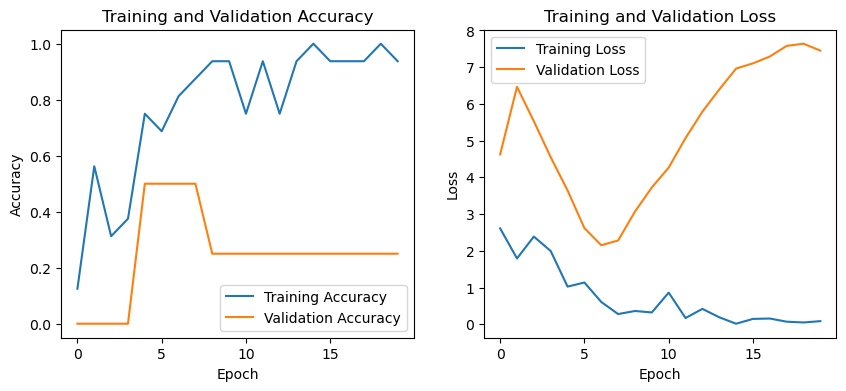

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━

In [8]:
if __name__ == "__main__":
    # Inisialisasi sistem
    face_recognition = FaceRecognitionTF(input_shape=(224, 224, 3), num_classes=6)  # Sesuaikan jumlah kelas

    # Build model
    model = face_recognition.build_model()

    # Siapkan data
    data_dir = "C:/Users/chesa/OneDrive/Documents/Kuliah/Porto programming/Data Sample/people"
    X_train, X_test, y_train, y_test = face_recognition.prepare_data(data_dir)

    # Train model
    history = face_recognition.train(X_train, y_train, X_test, y_test, epochs=20, batch_size=32)

    face_recognition.plot_training_history(history)
    
    # Jalankan face recognition real-time
    face_recognition.run_realtime_recognition()